(ONGOING and UNFINISHED) In this notebook, I'll fit and evaluate a simple one-layer KAN to the Delaney Aqueous Solubility dataset, and then investigate feature importance and the shape of activation functions.

In [219]:
# for imports
import sys
sys.path.append('../..')

# normal python data science stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from tqdm import tqdm

# my utility functions
from utils.data_utils import get_all_descriptors_from_smiles_list

# KAN imports
from kan import KAN

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [220]:
filepath = '../../datasets/aqueous_solubility_delaney.csv'
df_delaney = pd.read_csv(filepath)
df_delaney.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [221]:
# get list of smiles strings
smiles_list = list(df_delaney.SMILES)

# compute all molecular descriptors and store in pandas dataframe
descriptors_df = get_all_descriptors_from_smiles_list(smiles_list, as_dataframe=True)

100%|██████████| 1144/1144 [00:08<00:00, 141.25it/s]


In [222]:
descriptors_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.116512,5.116512,0.039352,-1.276235,0.487138,12.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.060957,5.060957,1.083333,-1.083333,0.445171,12.00,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.114198,5.114198,0.672840,-0.672840,0.527312,11.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.095679,5.095679,0.308642,-0.405864,0.480258,9.60,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.544753,11.544753,3.685957,-4.226080,0.553756,14.25,187.375,187.375,185.901768,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [223]:
# extract X and y from dataframes
X = descriptors_df.copy()
y = df_delaney['measured log(solubility:mol/L)'].values

X.shape, y.shape

((1144, 210), (1144,))

In [224]:
# split data into training and testing sets
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(descriptors_df, y, test_size=test_size, random_state=1738)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((915, 210), (229, 210), (915,), (229,))

In [225]:
selector = VarianceThreshold(threshold = 1e-6)

X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

selector.get_feature_names_out()

array(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt',
       'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge',
       'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3',
       'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4',
       'SMR_VSA5'

In [226]:
# get the names of the features that were removed
removed_features = [name for name in selector.feature_names_in_ if name not in selector.get_feature_names_out()]
removed_features

['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 'fr_Al_COO',
 'fr_Ar_COO',
 'fr_COO',
 'fr_COO2',
 'fr_amidine',
 'fr_azide',
 'fr_diazo',
 'fr_hdrzone',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_morpholine',
 'fr_nitroso',
 'fr_prisulfonamd',
 'fr_quatN',
 'fr_tetrazole',
 'fr_thiocyan']

In [227]:
# standardize features
scaler = StandardScaler()

# fit on training data only to avoid leakage
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [228]:
# convert to tensors
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [229]:
# make sure it's standardized correctly
assert torch.allclose(X_train_scaled.mean(axis=0), torch.zeros(X_train.shape[1]), atol=1e-6) \
and \
torch.allclose(X_train_scaled.std(axis=0), torch.ones(X_train.shape[1]), atol=0.01)

Text(0, 0.5, 'Standard Deviation')

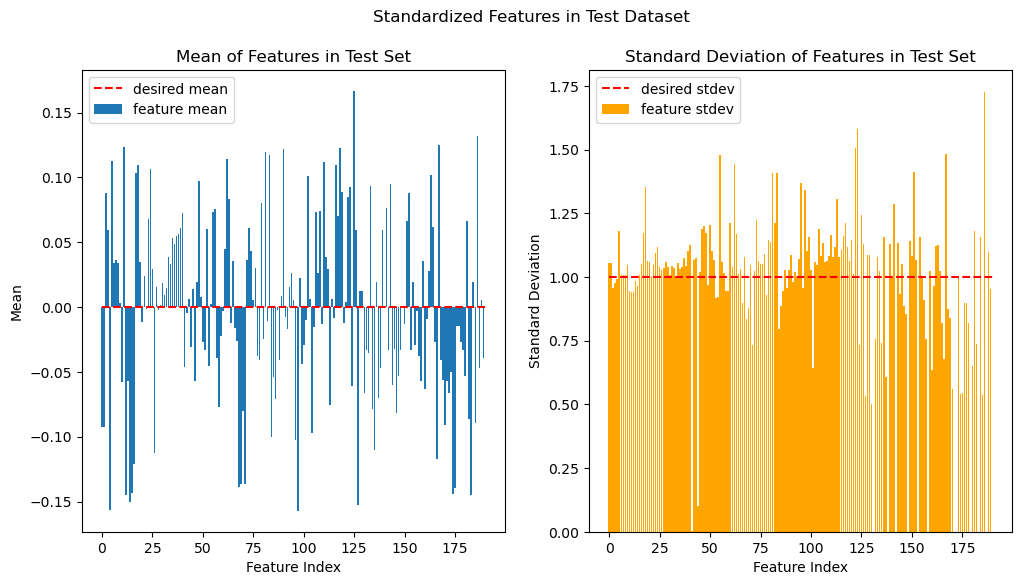

In [230]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

fig.suptitle('Standardized Features in Test Dataset')

# bar chart of means
ax[0].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.mean(axis=0))

ax[0].hlines(y=0, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[0].legend(['desired mean', 'feature mean'])

ax[0].set_title('Mean of Features in Test Set')

ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Mean')


# bar chart of standard deviations
ax[1].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.std(axis=0), color='orange')

ax[1].hlines(y=1, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[1].legend(['desired stdev', 'feature stdev'])  

ax[1].set_title('Standard Deviation of Features in Test Set')

ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Standard Deviation')

# Train Full Model (one-layer KAN)

In [231]:
# instantiate model
num_features = X_train_scaled.shape[1]

torch.manual_seed(1738) 

model = KAN(width=[num_features, 1])

checkpoint directory created: ./model
saving model version 0.0


In [232]:
model

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [233]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses = torch.zeros(size=(num_itrs,))
test_mses = torch.zeros(size=(num_itrs,))

train_r2s = torch.zeros(size=(num_itrs,))
test_r2s = torch.zeros(size=(num_itrs,))

train_maes = torch.zeros(size=(num_itrs,))
test_maes = torch.zeros(size=(num_itrs,))

train_rmses = torch.zeros(size=(num_itrs,))
test_rmses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = model(X_train_scaled)[:, 0]

    train_mse = F.mse_loss(y_hat_train, y_train)
    train_mae = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse = torch.sqrt(train_mse.detach())
    train_r2 = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse.requires_grad and y_hat_train.requires_grad
    assert not train_mae.requires_grad and not train_rmse.requires_grad and not train_r2.requires_grad
    
    train_mse.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses[i] = train_mse.detach()
    train_maes[i] = train_mae
    train_rmses[i] = train_rmse
    train_r2s[i] = train_r2

    # test
    y_hat_test = model(X_test_scaled).detach()[:, 0]

    test_mse = F.mse_loss(y_hat_test, y_test)
    test_mae_loss = F.l1_loss(y_hat_test, y_test)
    test_rmse_loss = torch.sqrt(test_mse)
    test_r2 = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses[i] = test_mse
    test_maes[i] = test_mae_loss
    test_rmses[i] = test_rmse_loss
    test_r2s[i] = test_r2

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse.item()}, r2: {train_r2.item()}, mae: {train_mae.item()}, rmse: {train_rmse.item()}')
        print(f'test iteration {i}, mse: {test_mse.item()}, r2: {test_r2.item()}, mae: {test_mae_loss.item()}, rmse: {test_rmse_loss.item()}')

train iteration 0, mse: 12.895803451538086, r2: -2.0025646686553955, mae: 3.0036845207214355, rmse: 3.5910727977752686
test iteration 0, mse: 4.9873857498168945, r2: -0.04438817501068115, mae: 1.7114253044128418, rmse: 2.233245611190796
train iteration 50, mse: 0.3938608765602112, r2: 0.9082962870597839, mae: 0.48256388306617737, rmse: 0.627583384513855
test iteration 50, mse: 0.5505008101463318, r2: 0.8847218751907349, mae: 0.5720452070236206, rmse: 0.741957426071167
train iteration 100, mse: 0.27660247683525085, r2: 0.9355978965759277, mae: 0.39864054322242737, rmse: 0.5259301066398621
test iteration 100, mse: 0.4885481894016266, r2: 0.8976951241493225, mae: 0.533860445022583, rmse: 0.6989622116088867
train iteration 150, mse: 0.2304677814245224, r2: 0.9463395476341248, mae: 0.36469101905822754, rmse: 0.4800705909729004
test iteration 150, mse: 0.4690711200237274, r2: 0.9017737507820129, mae: 0.5163073539733887, rmse: 0.6848876476287842
train iteration 200, mse: 0.20022164285182953, 

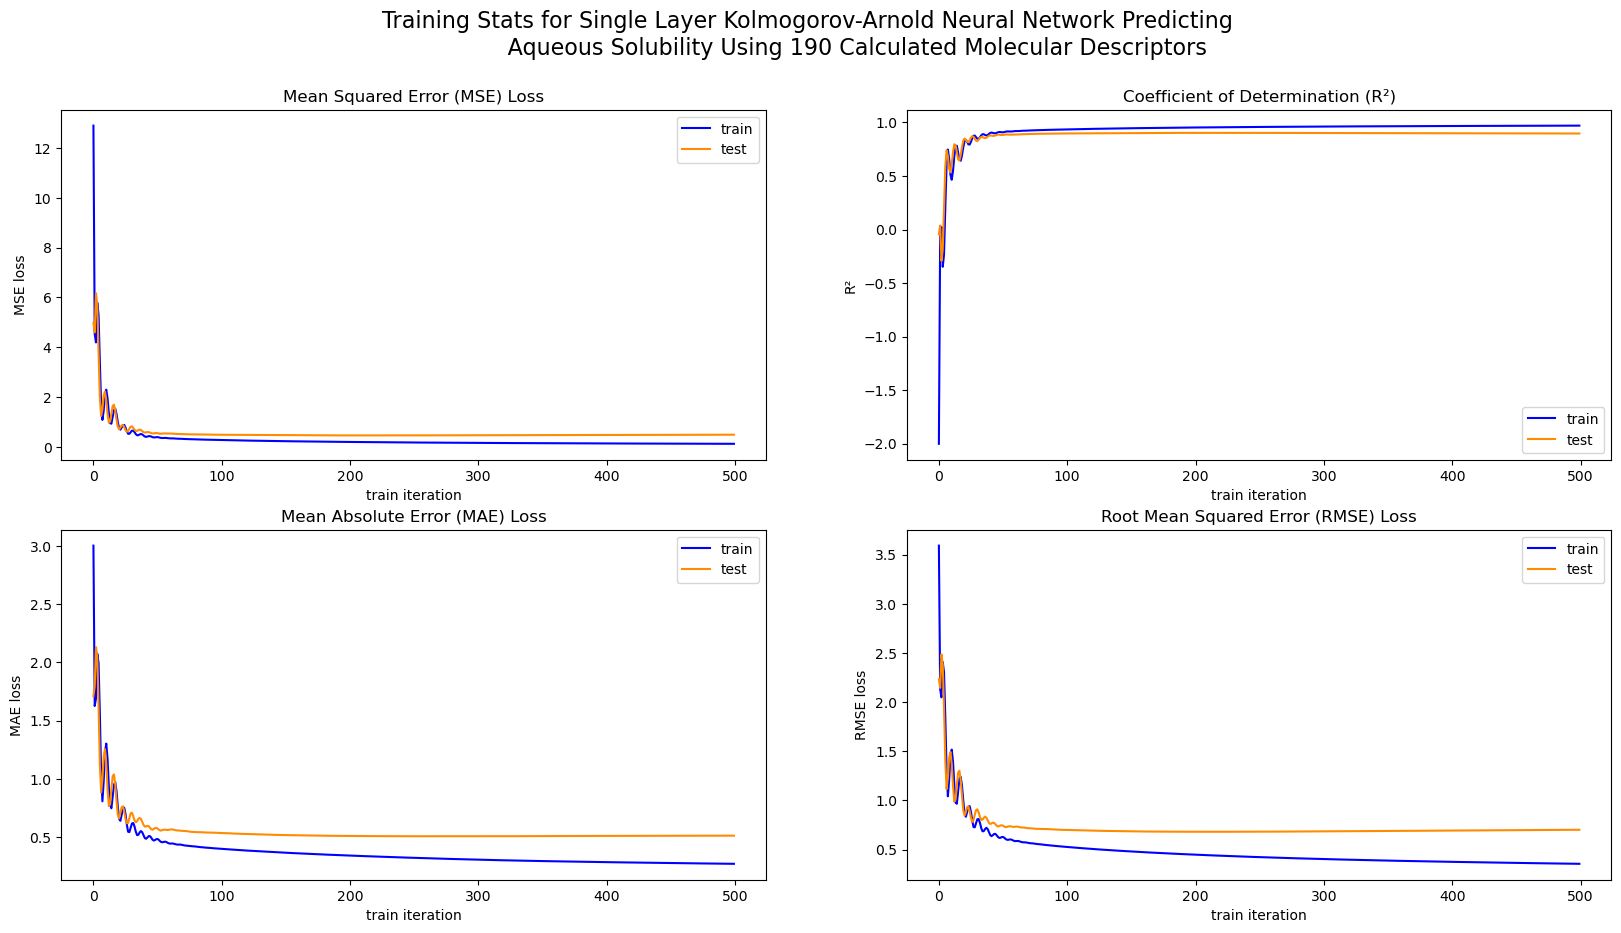

In [234]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting 
             Aqueous Solubility Using {X_train_scaled.shape[1]} Calculated Molecular Descriptors''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='blue')
ax[0, 0].plot(test_mses, c='darkorange')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train', 'test'])

# r2 plot
ax[0, 1].plot(train_r2s, c='blue')
ax[0, 1].plot(test_r2s, c='darkorange')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train', 'test'])

# mae plot
ax[1, 0].plot(train_maes, c='blue')
ax[1, 0].plot(test_maes, c='darkorange')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train', 'test'])

# rmse plot
ax[1, 1].plot(train_rmses, c='blue')
ax[1, 1].plot(test_rmses, c='darkorange')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train', 'test'])

# Investigating Activations

In [51]:
# I'm going to do this for the full dataset for now
X_scaled = torch.concat((X_train_scaled, X_test_scaled), axis=0)
X_scaled.shape

torch.Size([1144, 190])

In [52]:
y_hat = model(X_scaled)

In [53]:
# making sure I'm accessing the activations correctly
assert torch.allclose(model.spline_postacts[0][:, 0, :].sum(axis=1).unsqueeze(dim=1), model(X_scaled))
# the sum of the activations should be equal to the output of the model

In [54]:
# get the activations
activations = model.spline_postacts[0][:, 0, :]
assert activations.shape == X_scaled.shape, 'shape of activations should match shape of input data for one-layer KAN (num_samples, num_features)'
activations.shape # should be (num_samples, num_features)

torch.Size([1144, 190])

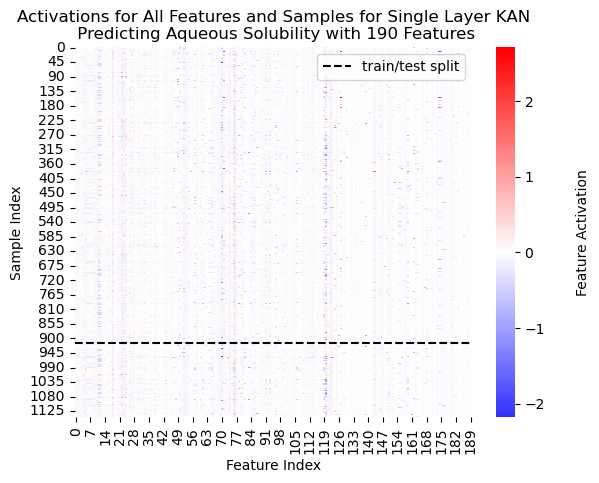

In [238]:
# visualizing all activations for all training samples
sns.heatmap(activations, cmap='bwr', center=0)
plt.title(f'Activations for All Features and Samples for Single Layer KAN\n Predicting Aqueous Solubility with {X_scaled.shape[1]} Features')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')

plt.text(x=240, y=760, s='Feature Activation', color='black', rotation='vertical')

plt.axhline(y=X_train_scaled.shape[0], xmin=0, xmax=X_scaled.shape[1], color='black', linestyle='dashed')
plt.legend(['train/test split'])
plt.show()

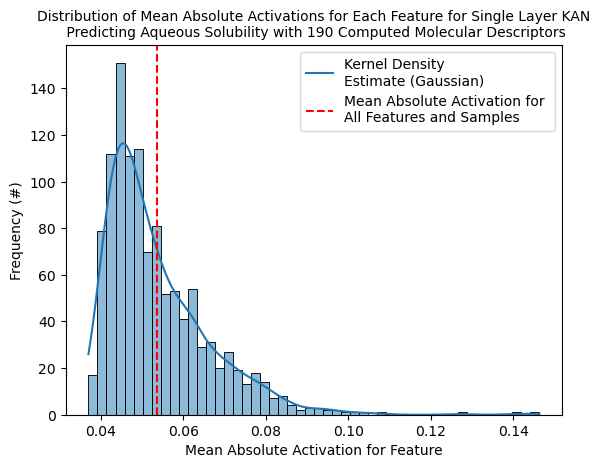

In [272]:
mean_abs_activations = activations.abs().mean(axis=1)
sns.histplot(mean_abs_activations, bins=50, kde=True)
plt.title(f'Distribution of Mean Absolute Activations for Each Feature for Single Layer KAN\n Predicting Aqueous Solubility with {X_scaled.shape[1]} Computed Molecular Descriptors', fontsize=10)
plt.xlabel('Mean Absolute Activation for Feature')
plt.ylabel('Frequency (#)')

plt.axvline(x=mean_abs_activations.mean(), color='r', linestyle='dashed')

plt.legend(['Kernel Density \nEstimate (Gaussian)', 'Mean Absolute Activation for \nAll Features and Samples'])

plt.show()

# Feature Selection Using Pearson Correlation Coefficients

In [57]:
# get the correlation matrix
corrcoefs = torch.corrcoef(X_train_scaled.T)
assert corrcoefs.shape == (X_train_scaled.shape[1], X_train_scaled.shape[1]), 'correlation matrix should be square and have shape (num_features, num_features)'
assert corrcoefs.shape == (selector.get_feature_names_out().shape[0], selector.get_feature_names_out().shape[0]), \
'correlation matrix should have the same number of features as the feature names after variance thresholding feature selection'
corrcoefs.shape

torch.Size([190, 190])

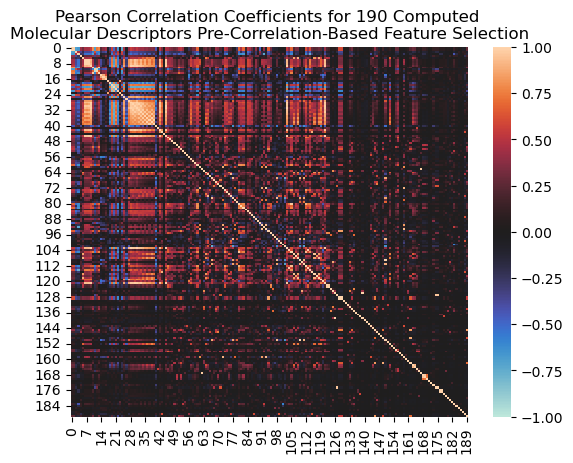

In [126]:
sns.heatmap(corrcoefs, center=0, vmin=-1, vmax=1)
plt.title(f'Pearson Correlation Coefficients for {X_train_scaled.shape[1]} Computed \nMolecular Descriptors Pre-Correlation-Based Feature Selection')
plt.show()

In [258]:
"""
Iterate through the features, keep the first, remove the rest that are highly correlated with it
"""

correlation_threshold = 0.9
retained_feature_idxs = []
removed_feature_idxs = []

corrcoefs_abs = corrcoefs.abs()

for feature_idx, feature_correlations in enumerate(corrcoefs_abs):
    if feature_idx in removed_feature_idxs:
        # if this feature was already removed, skip it
        continue

    else:
        # add the feature itself to the list of retained features
        retained_feature_idxs.append(feature_idx)

        # get the indices of the features that are highly correlated with this feature
        highly_correlated_feature_idxs = torch.where(feature_correlations > correlation_threshold)[0]

        # remove the feature itself
        highly_correlated_feature_idxs = highly_correlated_feature_idxs[highly_correlated_feature_idxs != feature_idx]

        # add the indices of the highly correlated features to the list of removed features
        removed_feature_idxs.extend(highly_correlated_feature_idxs.tolist())
    
# remove duplicates
removed_feature_idxs = list(set(removed_feature_idxs))
retained_feature_idxs = list(set(retained_feature_idxs))

In [259]:
num_features_retained = len(removed_feature_idxs)
num_features_removed = len(retained_feature_idxs)

assert num_features_retained + num_features_removed == X_train_scaled.shape[1], 'number of retained and removed features should sum to total number of features'

print('number of features to remove: ', num_features_removed, \
'\nnumber of features to retain: ', num_features_retained)

number of features to remove:  151 
number of features to retain:  39


In [260]:
# keep track of the names of the features that were retained and removed
features_retained_after_variance_selection = selector.get_feature_names_out()
assert len(features_retained_after_variance_selection) == X_train_scaled.shape[1], 'number of feature names from selector should match number of features in training data'
features_retained_after_correlation_selection = features_retained_after_variance_selection[retained_feature_idxs]
features_removed_after_correlation_selection = features_retained_after_variance_selection[removed_feature_idxs]
assert len(features_retained_after_correlation_selection) + len(features_removed_after_correlation_selection) == X_train_scaled.shape[1], 'number of retained and removed features should sum to total number of features'
# ... yes, I AM that paranoid

print(f'features that were removed via correlation-based selection: \n{features_removed_after_correlation_selection}')

features that were removed via correlation-based selection: 
['MaxEStateIndex' 'fr_C_O_noCOO' 'HeavyAtomMolWt' 'ExactMolWt'
 'NumValenceElectrons' 'fr_Nhpyrrole' 'MaxAbsPartialCharge'
 'MinAbsPartialCharge' 'BCUT2D_CHGLO' 'fr_benzene' 'Chi0' 'Chi0v' 'Chi1'
 'Chi1n' 'Chi1v' 'Chi2n' 'fr_halogen' 'fr_ketone_Topliss' 'Chi3v' 'Chi4n'
 'Chi4v' 'fr_nitrile' 'fr_nitro_arom' 'Kappa1' 'LabuteASA' 'fr_phenol'
 'fr_phenol_noOrthoHbond' 'fr_phos_ester' 'SlogP_VSA5' 'SlogP_VSA6'
 'VSA_EState10' 'HeavyAtomCount' 'NOCount' 'NumAliphaticRings'
 'NumAromaticCarbocycles' 'NumHDonors' 'NumSaturatedCarbocycles' 'MolMR'
 'fr_Al_OH_noTert']


In [261]:
# filter the training and testing data to only include the retained features
X_train_scaled_corr_filtered = X_train_scaled[:, retained_feature_idxs]
X_test_scaled_corr_filtered = X_test_scaled[:, retained_feature_idxs]

X_train_scaled_corr_filtered.shape, X_test_scaled_corr_filtered.shape

(torch.Size([915, 151]), torch.Size([229, 151]))

In [268]:
# make sure correlaton coefficient based feature selection worked
assert torch.sum(torch.corrcoef(X_train_scaled_corr_filtered.T).abs() > correlation_threshold) == X_train_scaled_corr_filtered.shape[1], \
'all features should have correlation coefficients below the threshold except with themselves'

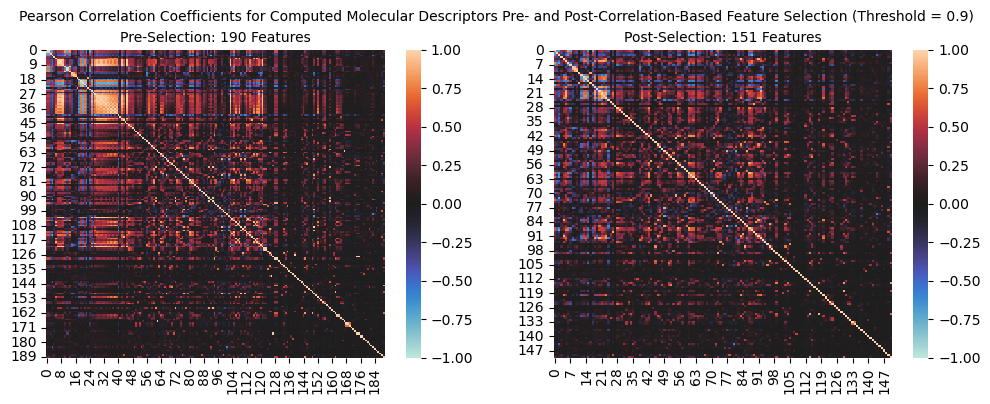

In [263]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle(f'Pearson Correlation Coefficients for Computed Molecular Descriptors Pre- and Post-Correlation-Based Feature Selection (Threshold = {correlation_threshold})', fontsize=10)

ax[0].set_title(f'Pre-Selection: {X_train_scaled.shape[1]} Features', fontsize=10)
sns.heatmap(data=corrcoefs, ax=ax[0], center=0, vmin=-1, vmax=1)

ax[1].set_title(f'Post-Selection: {X_train_scaled_corr_filtered.shape[1]} Features', fontsize=10)
sns.heatmap(data=torch.corrcoef(X_train_scaled_corr_filtered.T), ax=ax[1], center=0, vmin=-1, vmax=1)
plt.show()

# Train Reduced Model

In [264]:
torch.manual_seed(1738)

model_reduced = KAN(width=[X_train_scaled_corr_filtered.shape[1], 1])

checkpoint directory created: ./model
saving model version 0.0


In [265]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model_reduced.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses_red = torch.zeros(size=(num_itrs,))
test_mses_red = torch.zeros(size=(num_itrs,))

train_r2s_red = torch.zeros(size=(num_itrs,))
test_r2s_red = torch.zeros(size=(num_itrs,))

train_maes_red = torch.zeros(size=(num_itrs,))
test_maes_red = torch.zeros(size=(num_itrs,))

train_rmses_red = torch.zeros(size=(num_itrs,))
test_rmses_red = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = model_reduced(X_train_scaled_corr_filtered)[:, 0]

    train_mse_red = F.mse_loss(y_hat_train, y_train)
    train_mae_red = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse_red = torch.sqrt(train_mse_red.detach())
    train_r2_red = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse_red.requires_grad and y_hat_train.requires_grad
    assert not train_maes_red.requires_grad and not train_rmse_red.requires_grad and not train_r2_red.requires_grad
    
    train_mse_red.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses_red[i] = train_mse_red.detach()
    train_maes_red[i] = train_mae_red
    train_rmses_red[i] = train_rmse_red
    train_r2s_red[i] = train_r2_red

    # test
    y_hat_test = model_reduced(X_test_scaled_corr_filtered).detach()[:, 0]

    test_mse_red = F.mse_loss(y_hat_test, y_test)
    test_mae_red = F.l1_loss(y_hat_test, y_test)
    test_rmse_red = torch.sqrt(test_mse_red)
    test_r2_red = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses_red[i] = test_mse_red
    test_maes_red[i] = test_mae_red
    test_rmses_red[i] = test_rmse_red
    test_r2s_red[i] = test_r2_red

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse_red.item()}, r2: {train_r2_red.item()}, mae: {train_mae_red.item()}, rmse: {train_rmse_red.item()}')
        print(f'test iteration {i}, mse: {test_mse_red.item()}, r2: {test_r2_red.item()}, mae: {test_mae_red.item()}, rmse: {test_rmse_red.item()}')

train iteration 0, mse: 13.630378723144531, r2: -2.173598051071167, mae: 3.007108688354492, rmse: 3.69193434715271
test iteration 0, mse: 6.7159318923950195, r2: -0.4063558578491211, mae: 2.0206940174102783, rmse: 2.5915114879608154
train iteration 50, mse: 0.420157790184021, r2: 0.9021735191345215, mae: 0.4982396960258484, rmse: 0.6481958031654358
test iteration 50, mse: 0.575323224067688, r2: 0.8795238733291626, mae: 0.5967134237289429, rmse: 0.7585006356239319
train iteration 100, mse: 0.29962387681007385, r2: 0.9302377700805664, mae: 0.4153464436531067, rmse: 0.5473790764808655
test iteration 100, mse: 0.47060826420783997, r2: 0.901451826095581, mae: 0.5298960208892822, rmse: 0.6860089302062988
train iteration 150, mse: 0.2530321180820465, r2: 0.9410858750343323, mae: 0.3808920681476593, rmse: 0.5030229687690735
test iteration 150, mse: 0.4459593892097473, r2: 0.9066134691238403, mae: 0.5081143975257874, rmse: 0.6678019165992737
train iteration 200, mse: 0.22169069945812225, r2: 0.

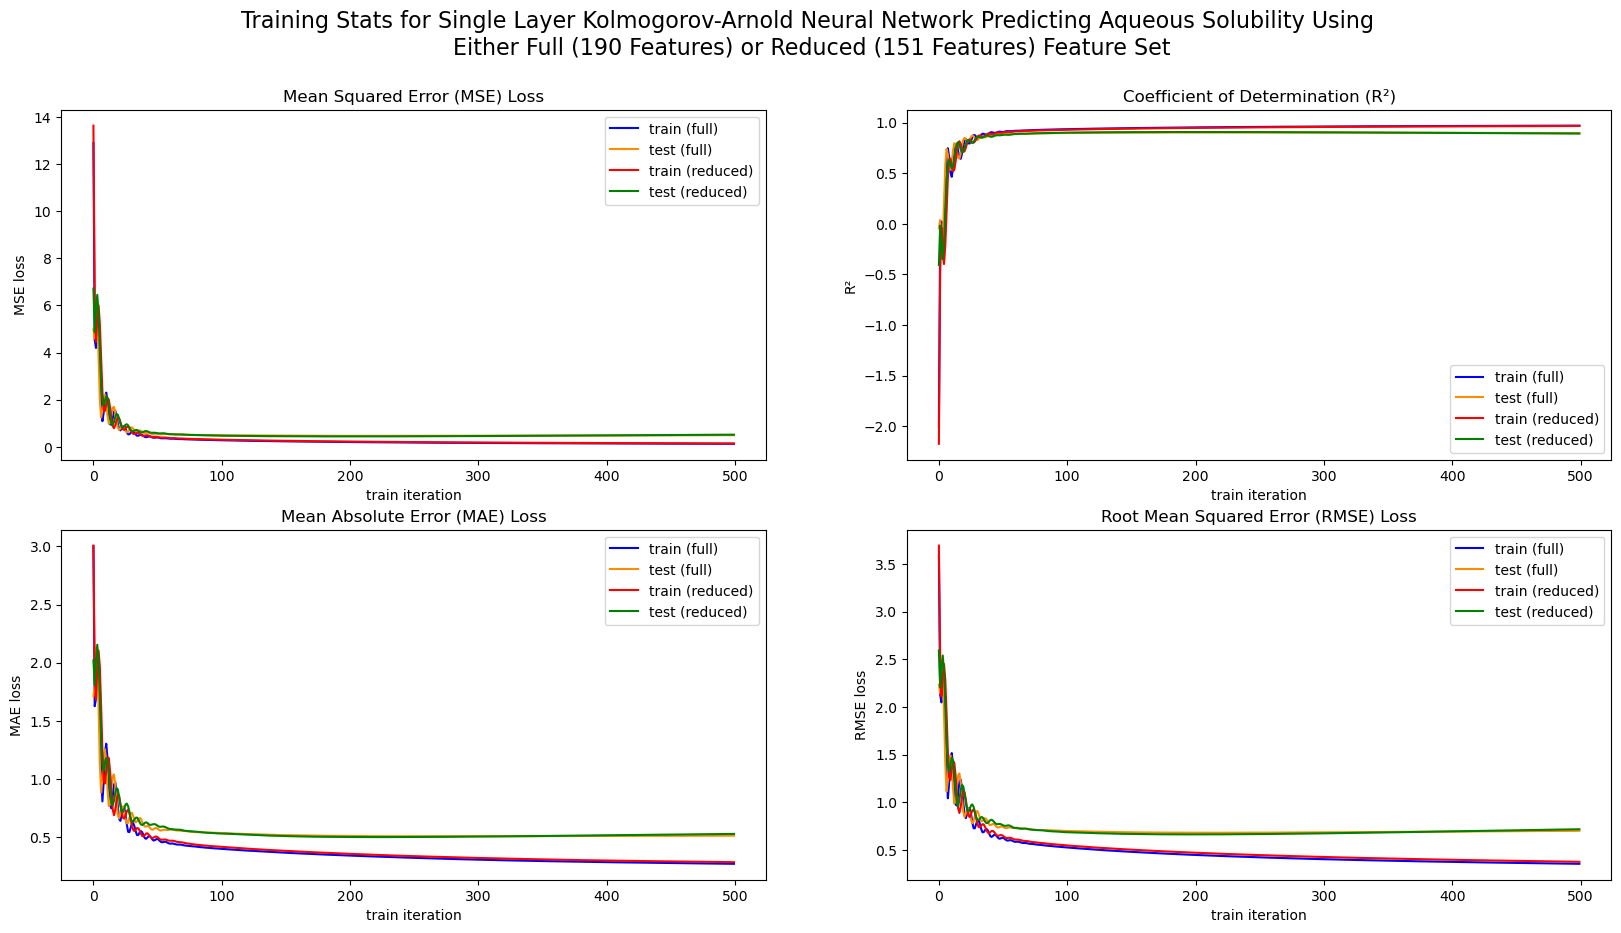

In [266]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting Aqueous Solubility Using \nEither Full ({X_train_scaled.shape[1]} Features) or Reduced ({X_train_scaled_corr_filtered.shape[1]} Features) Feature Set''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='blue')
ax[0, 0].plot(test_mses, c='darkorange')
ax[0, 0].plot(train_mses_red, c='red')
ax[0, 0].plot(test_mses_red, c='green')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# r2 plot
ax[0, 1].plot(train_r2s, c='blue')
ax[0, 1].plot(test_r2s, c='darkorange')
ax[0, 1].plot(train_r2s_red, c='red')
ax[0, 1].plot(test_r2s_red, c='green')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# mae plot
ax[1, 0].plot(train_maes, c='blue')
ax[1, 0].plot(test_maes, c='darkorange')
ax[1, 0].plot(train_maes_red, c='red')
ax[1, 0].plot(test_maes_red, c='green')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# rmse plot
ax[1, 1].plot(train_rmses, c='blue')
ax[1, 1].plot(test_rmses, c='darkorange')
ax[1, 1].plot(train_rmses_red, c='red')
ax[1, 1].plot(test_rmses_red, c='green')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])